
# Hyperparameter Optimization For Customer's Credit Scoring Model


<div class="alert alert-success">

The dataset consists of data about 1000 customers, encompassing 84 features extracted from their financial transactions and current financial status. The main aim is to utilize this dataset for credit risk assessment and forecasting potential defaults.

Included within are two target variables, one designed for classification and the other for regression analysis:

- **DEFAULT**: Binary target variable indicating if the customer has defaulted (1) or not (0)
- **CREDIT_SCORE**: Numerical target variable representing the customer's credit score (integer)

and these features:

- **INCOME**: Total income in the last 12 months
- **SAVINGS**: Total savings in the last 12 months
- **DEBT**: Total existing debt
- **R_SAVINGS_INCOME**: Ratio of savings to income
- **R_DEBT_INCOME**: Ratio of debt to income
- **R_DEBT_SAVINGS**: Ratio of debt to savings

Transaction groups (**GROCERIES**, **CLOTHING**, **HOUSING**, **EDUCATION**, **HEALTH**, **TRAVEL**, **ENTERTAINMENT**, **GAMBLING**, **UTILITIES**, **TAX**, **FINES**) are categorized.

- **T_{GROUP}_6**: Total expenditure in that group in the last 6 months
- **T_GROUP_12**: Total expenditure in that group in the last 12 months
- **R_[GROUP]**: Ratio of T_[GROUP]6 to T[GROUP]_12
- **R_[GROUP]INCOME**: Ratio of T[GROUP]_12 to INCOME
- **R_[GROUP]SAVINGS**: Ratio of T[GROUP]_12 to SAVINGS
- **R_[GROUP]DEBT**: Ratio of T[GROUP]_12 to DEBT

Categorical Features:

- **CAT_GAMBLING**: Gambling category (none, low, high)
- **CAT_DEBT**: 1 if the customer has debt; 0 otherwise
- **CAT_CREDIT_CARD**: 1 if the customer has a credit card; 0 otherwise
- **CAT_MORTGAGE**: 1 if the customer has a mortgage; 0 otherwise
- **CAT_SAVINGS_ACCOUNT**: 1 if the customer has a savings account; 0 otherwise
- **CAT_DEPENDENTS**: 1 if the customer has any dependents; 0 otherwise
- **CAT_LOCATION**: Location (San Francisco, Philadelphia, Los Angeles, etc.)
- **CAT_MARITAL_STATUS**: Marital status (Married, Widowed, Divorced or Single)
- **CAT_EDUCATION**: Level of Education (Postgraduate, College, High School or Graduate)

</div>

In [1]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

<div class="alert alert-info"><b>Loading Data</b>

We load the data in a DataFrame called ```df```.
    
Then, we create the feature matrix ```X``` and the target array ```y``` (```DEFAULT```), then we split them into separate training and test sets with a relative size of 0.75 and 0.25.

```CREDIT_SCORE``` will be used later for the regression.
</div>

In [2]:
from sklearn.model_selection import train_test_split

df=pd.read_csv('AI2_23_24_credit_score.csv')
df.drop(columns='CUST_ID',inplace=True)

X=df.drop(columns=['CREDIT_SCORE', 'DEFAULT'])
y=df['DEFAULT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<div class="alert alert-info"><b>Pipeline for Model</b>

We construct a two-branched `Pipeline` – one branch for categorical attributes and another for numerical attributes. For categorical variables, we employ a `SimpleImputer` with the most frequent strategy and an `OneHotEncoder`. For numerical attributes, we use a `SimpleImputer` with the mean and a `StandardScaler`.
</div>


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

categorical_features = X_train.select_dtypes(include=['object']).columns # to check as CAT features in theory are categorical
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

steps_categorical = [('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]

steps_numerical = [('imputer', SimpleImputer(strategy='mean')),
                     ('scaler', StandardScaler())]

pipe_categorical = Pipeline(steps=steps_categorical)
pipe_numerical = Pipeline(steps=steps_numerical)

preprocessor = ColumnTransformer(transformers=[('num', pipe_numerical, numerical_features),
                                                  ('cat', pipe_categorical, categorical_features)])

steps_pipe = [('preprocessor', preprocessor),
                ('classifier', DecisionTreeClassifier())]

pipe = Pipeline(steps=steps_pipe)

<div class="alert alert-info"><b>Model Performance</b>

We estimate the performance of the model using cross-validation with **five** stratified folds.
</div>

In [19]:
from sklearn.model_selection import cross_val_score
fold_scores = {'fold_score_'+str(i+1): score for i, score in enumerate(cross_val_score(pipe, X_train, y_train, cv=5))}
print(fold_scores)

{'fold_score_1': 0.6266666666666667, 'fold_score_2': 0.6133333333333333, 'fold_score_3': 0.6933333333333334, 'fold_score_4': 0.6533333333333333, 'fold_score_5': 0.6066666666666667}


<div class="alert alert-info"><b>Grid Search</b>

We instantiate a ```GridSearchCV``` object named `grid`. This ```GridSearchCV``` object incorporates the previous pipeline and explores diverse hyperparameters to enhance the predictive capability of the previous `DecisionTreeClassifier`.
</div>

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__criterion' : ['gini', 'entropy'], # it might be interesting to see how different split criterias influence the results
    'classifier__max_depth' : [None, 5, 10], # None might cause overfitting, 5 under and 10 might just be right
    'classifier__min_samples_split' : [2, 10], # 2 might cause overfitting, 10 might be just right
    'classifier__min_samples_leaf' : [1, 5] # 1 might cause overfitting, 5 might be just right
}

grid = GridSearchCV(pipe, param_grid, cv=3)
grid.fit(X_train, y_train)

score=grid.best_score_
print(score)

0.7093333333333334


<div class="alert alert-info"><b>Generalization Score</b>

</div>

In [27]:
generalization_score=grid.score(X_test, y_test)

<div class="alert alert-info"><b>Expanding Grid Search</b>
    
The previous grid search is incomplete because it only optimizes the hyperparameters of the decision tree classifier. Now, we replicate the same process but expand the scope to include testing parameters of all the steps within the pipeline for a regression task, with the CREDIT_SCORE attribute as the target array.
</div>

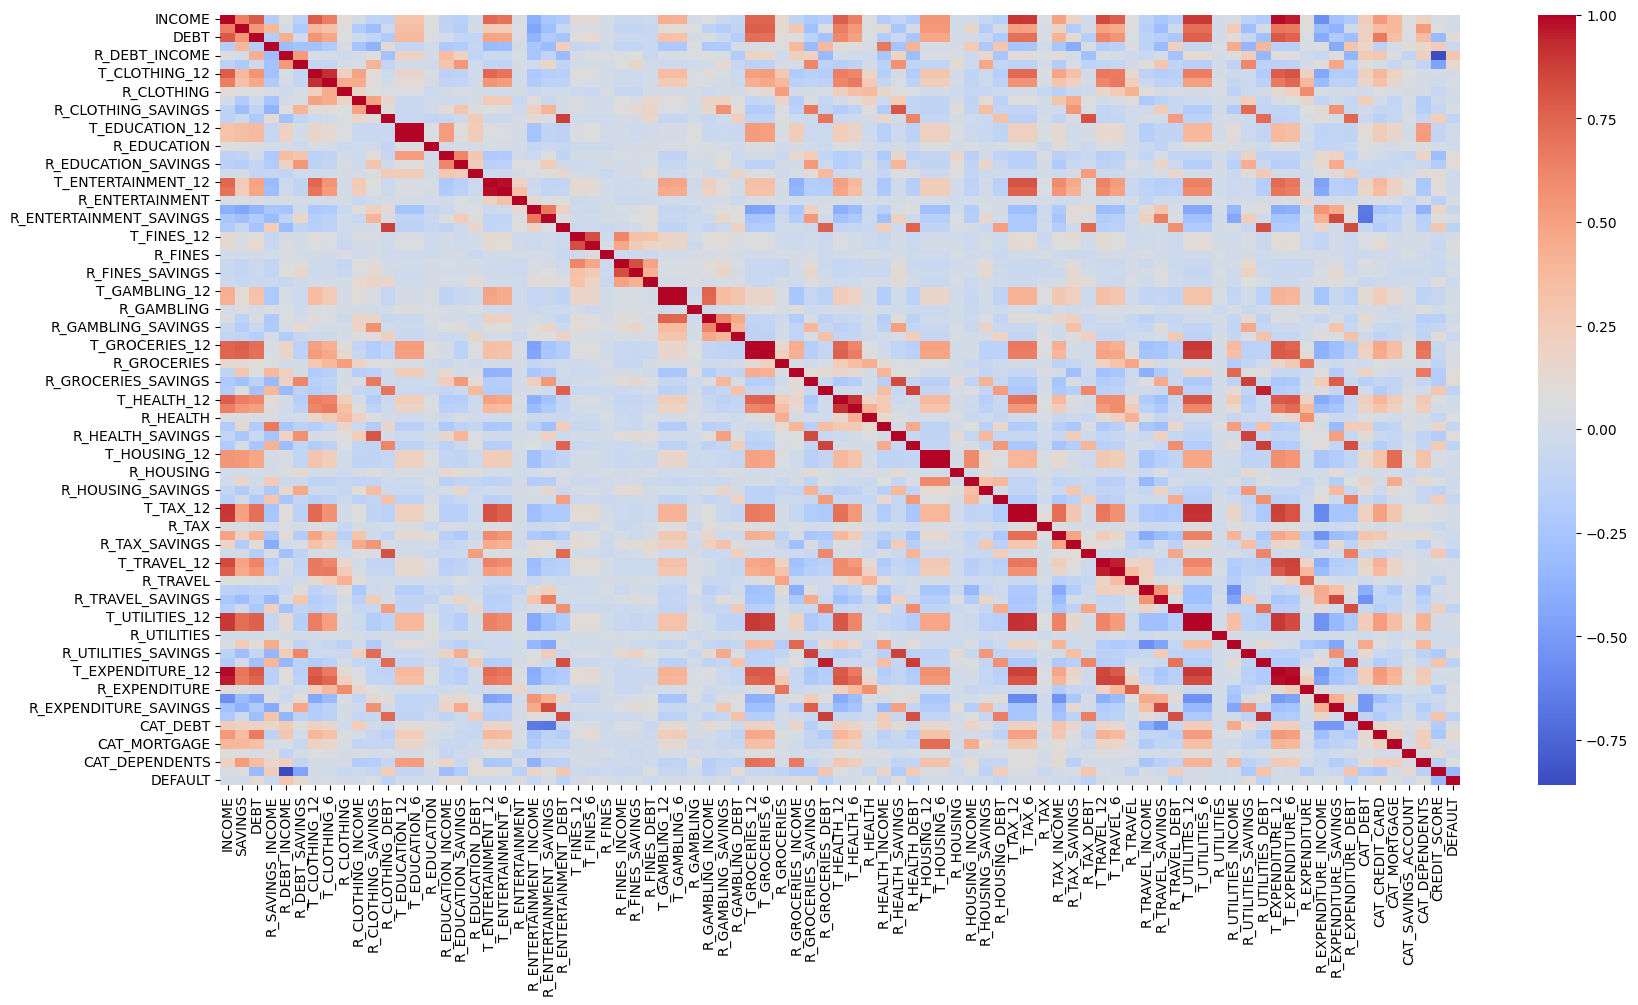

In [29]:
# Calculate correlation matrix
from matplotlib import pyplot as plt
import seaborn as sns
numeric_data = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr()

# Display the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [30]:
import pandas as pd
import numpy as np

# To simplify dtataframe, we will drop columns with high correlation to each other and low with the target column
# The dataframe will be simpler and faster to be processed, but we will use some information, especially with non-linear models
def drop_low_corr_columns(df, target_col, threshold=0.9):
    df2 = df.copy()

    
    # Loop until no more highly correlated columns
    while True:
        numeric_data = df2.select_dtypes(include=['float64', 'int64'])
        corr_matrix = numeric_data.corr().abs()

        # Exclude the target column from correlation calculation
        corr_matrix = corr_matrix.drop(target_col, axis=0).drop(target_col, axis=1)
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Find the two largest correlation coefficients in the upper triangular part
        two_largest_corr = upper_tri.unstack().sort_values(ascending=False)[:1]

        if two_largest_corr.iloc[0] < threshold:
            break
        col1, col2 = two_largest_corr.index[0]
        corr1 = df2[col1].corr(df2[target_col])
        corr2 = df2[col2].corr(df2[target_col])

        # Drop the column with lower correlation with the target column
        if corr1 < corr2:
            drop_col = col1
        else:
            drop_col = col2
        df2 = df2.drop(drop_col, axis=1)
        print(f"Dropped column: {drop_col}")

        

    # Return df2 with the target column too
    return df2

# Usage
df_reduced = drop_low_corr_columns(df, 'CREDIT_SCORE', 0.8)

Dropped column: T_HOUSING_6
Dropped column: T_EDUCATION_12
Dropped column: T_UTILITIES_6
Dropped column: T_TAX_6
Dropped column: T_GAMBLING_6
Dropped column: T_GROCERIES_6
Dropped column: T_EXPENDITURE_12
Dropped column: T_ENTERTAINMENT_6
Dropped column: T_EXPENDITURE_6
Dropped column: R_GROCERIES_DEBT
Dropped column: T_TRAVEL_6
Dropped column: R_UTILITIES_DEBT
Dropped column: T_CLOTHING_6
Dropped column: T_UTILITIES_12
Dropped column: T_HEALTH_6
Dropped column: INCOME
Dropped column: R_UTILITIES_SAVINGS
Dropped column: R_CLOTHING_DEBT
Dropped column: R_EXPENDITURE_SAVINGS
Dropped column: R_ENTERTAINMENT_DEBT
Dropped column: R_HEALTH_SAVINGS
Dropped column: R_HEALTH_DEBT
Dropped column: R_FINES_SAVINGS
Dropped column: R_TRAVEL_DEBT
Dropped column: T_FINES_6
Dropped column: T_TAX_12


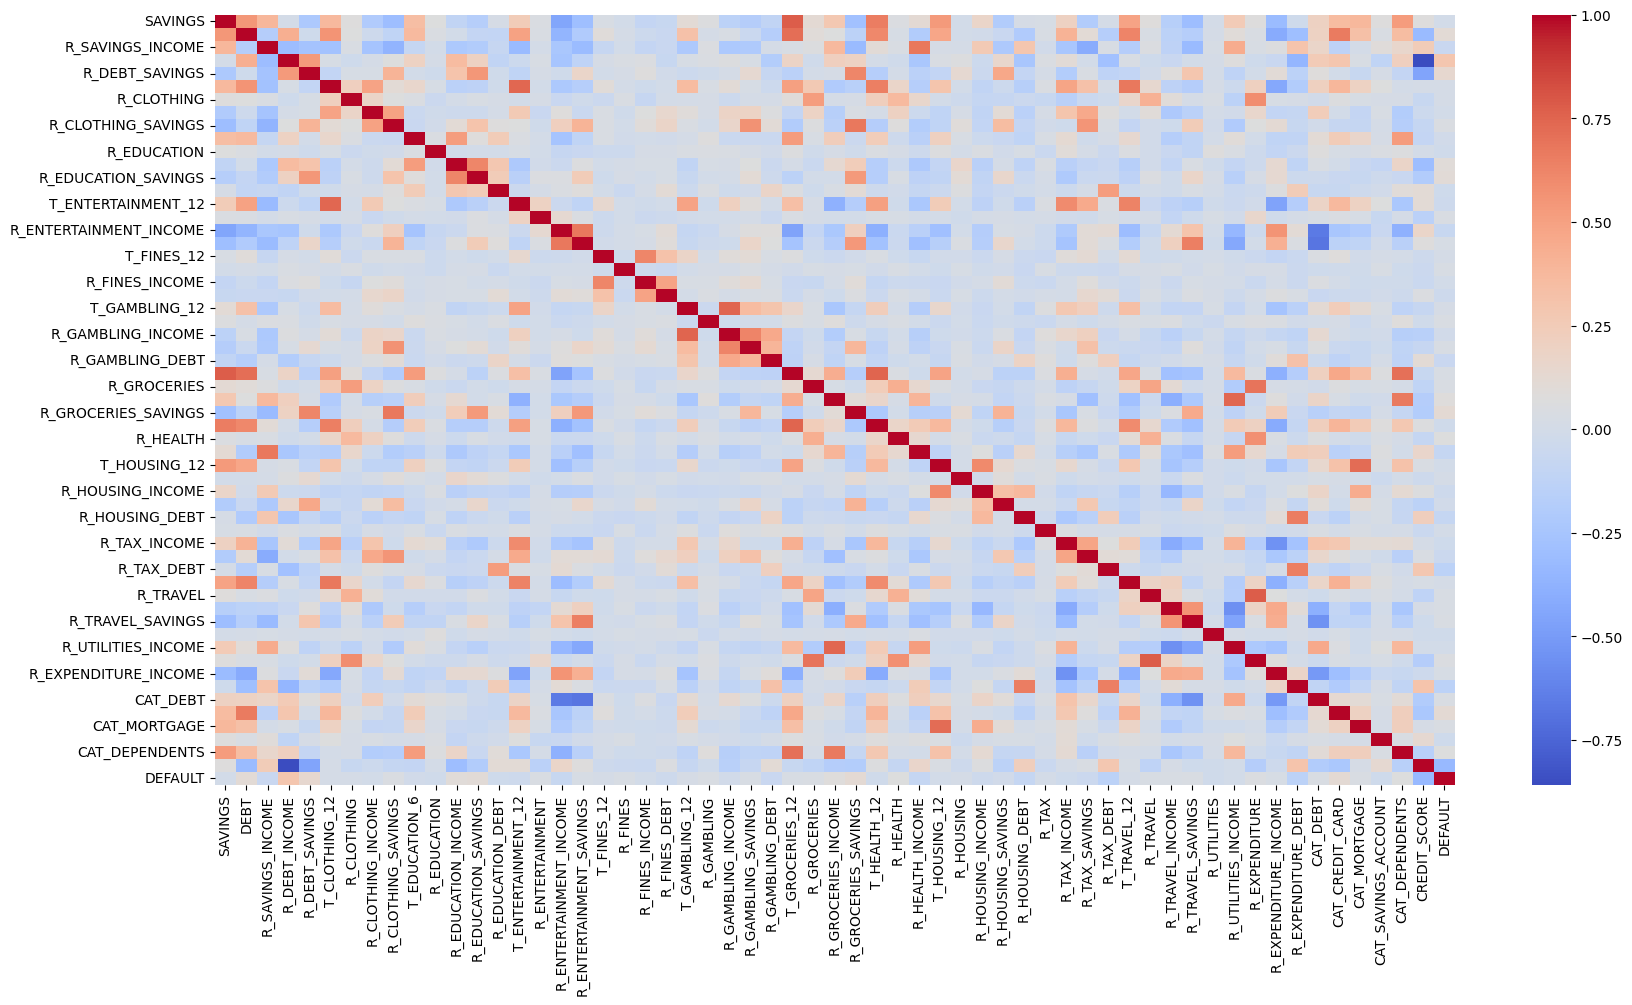

In [31]:
# Calculate correlation matrix
from matplotlib import pyplot as plt
import seaborn as sns
numeric_data = df_reduced.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr()

# Display the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [32]:
# We do thet test train split
from sklearn.model_selection import train_test_split

X=df_reduced.drop(columns=['CREDIT_SCORE', 'DEFAULT'])
y = df_reduced['CREDIT_SCORE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

# let's create a function to create the pipeline and evaluate them (it could be simpler but this allows us to try many different things)
def model_creation_evaluation(categorical_features_onehot, categorical_features_ordinal, numerical_features, ordinal_values, parameters, X_train, y_train):
    cat_transformer_divided=ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_onehot),
            ('ordinal', OrdinalEncoder(categories=ordinal_values), categorical_features_ordinal)], remainder='passthrough')


    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_transformer_divided', cat_transformer_divided)])

    # Combine preprocessing for numerical and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num_imputer', 'placeholder_num_imputer', numerical_features),
            ('cat', categorical_transformer, categorical_features)], remainder='passthrough')

    # Create a list to store the trained models
    trained_models = []
    type_scoring=['r2', 'neg_mean_absolute_error'] # To try different scoring methods, but not needed
    # Loop over the models and the hyperparameters
    i=0
    max_i=len(parameters)*len(type_scoring)
    for type_score in type_scoring:
        
        for param_grid in parameters:
            i=i+1
            pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('scaler', 'placeholder_scaler'),
                           ('model', 'placeholder_model')])
            grid_search = GridSearchCV(pipe, param_grid, scoring=type_score, cv=3, error_score=0, n_jobs=-1, verbose=1)
            grid_search.fit(X_train, y_train)
            trained_models.append(grid_search)
            print(i/max_i*100, '%')

    # Find the model with best score
    r2=make_scorer(r2_score) 
    best_model = max(trained_models, key=lambda model: cross_val_score(model.best_estimator_, X_train, y_train, cv=3, scoring=r2, n_jobs=-1).mean()) # we want to confront the same score
    return best_model, trained_models



In [34]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# Define the numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Define the categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns

# Define the different types of categorical features
categorical_features_onehot = ['CAT_LOCATION', 'CAT_MARITAL_STATUS']
categorical_features_ordinal = ['CAT_GAMBLING', 'CAT_EDUCATION']

gambling_values_ordinal = ['No', 'Low', 'High']
education_values_ordinal = ['High School', 'College', 'Graduate', 'Postgraduate']

# Let's create the different combinations of imputers, scalers and models to test

# We choose different hyperparameters for the imputers and scalers to test different combinations, but keeping it simple, no need to make it more complex
simple_num_imputer_grid = {
    'preprocessor__num_imputer': [SimpleImputer()],
    'preprocessor__num_imputer__strategy': ['mean', 'median', 'constant'], 
    'preprocessor__num_imputer__fill_value': [0]
}

knn_num_imputer_grid = {
    'preprocessor__num_imputer': [KNNImputer()],
    'preprocessor__num_imputer__n_neighbors': [3, 7],
    'preprocessor__num_imputer__weights': ['uniform', 'distance']
}

imputer_list = [simple_num_imputer_grid, knn_num_imputer_grid]

standardscaler_grid = {
    'scaler': [StandardScaler()]
}

robustscaler_grid = {
    'scaler': [RobustScaler()],
    'scaler__quantile_range':[(25.0, 75.0), (20.0, 70.0)]
}

minmaxscaler_grid = {
    'scaler': [MinMaxScaler()],
    'scaler__feature_range':[(0, 1), (-1, 1)]
}

scaler_list=[standardscaler_grid, robustscaler_grid, minmaxscaler_grid] # the hyperparameters chosen are the principal ones for the scalers

common_param_grid = {
    #'preprocessor__cat__imputer__strategy': ['most_frequent'], #, 'constant'], #no missing cat values in the dataset, so no reason to complicate it, we keep it in case of future changes
    #'preprocessor__cat__imputer__fill_value': ['missing'],
    'preprocessor__cat__cat_transformer_divided__onehot__drop': [None, 'first'] # to test if it is better to drop the first column of the onehot encoding due to correlation or not
}

# create combinations of imputer and scaler with common grid for the preprocessing part
common_grids = []
for imputer in imputer_list:
    for scaler in scaler_list:
        common_grids.append(imputer | scaler | common_param_grid)

param_grid_linear = {
    'model': [LinearRegression()]
}

param_grid_lasso = {
    'model': [Lasso()],
    'model__alpha': [0.1, 0.5, 1] # primary parameter for lasso
}

param_grid_rf = { # not using it for time reasons
    'model': [RandomForestRegressor()],
    'model__n_estimators': [100, 250],
    'model__max_depth': [5, 10],
    'model__min_samples_split': [5],
    'model__min_samples_leaf': [2]
}

param_grid_xgb = {
    'model': [XGBRegressor()],
    'model__n_estimators': [100, 200], # keeping it simple for now
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [10], # adding features to fine tune later (look at later code where it could turn out to be useful)
    'model__min_child_weight': [3]
}

param_grid_svr = {
    'model': [SVR()],
    'model__C': [0.1, 0.5, 1], # very different parameters to try, extreme ones and a good trade-off
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'rbf'], # more simple and more flexible
    'model__epsilon': [0.2] # to be optimized later
}

models_list=[param_grid_svr, param_grid_linear, param_grid_lasso, param_grid_xgb]#, param_grid_rf for semplicity and time saving (it should now take less than 10 minutes to run)

# Create combinations of models with common grids
param_grids = []
for model in models_list:
    for common_grid in common_grids:
        param_grids.append(model | common_grid)


best_model,trained_models=model_creation_evaluation(categorical_features_onehot, categorical_features_ordinal, numerical_features, [gambling_values_ordinal, education_values_ordinal], param_grids, X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


2.083333333333333 %
Fitting 3 folds for each of 144 candidates, totalling 432 fits
4.166666666666666 %
Fitting 3 folds for each of 144 candidates, totalling 432 fits
6.25 %
Fitting 3 folds for each of 96 candidates, totalling 288 fits
8.333333333333332 %
Fitting 3 folds for each of 192 candidates, totalling 576 fits
10.416666666666668 %
Fitting 3 folds for each of 192 candidates, totalling 576 fits
12.5 %
Fitting 3 folds for each of 6 candidates, totalling 18 fits
14.583333333333334 %
Fitting 3 folds for each of 12 candidates, totalling 36 fits
16.666666666666664 %
Fitting 3 folds for each of 12 candidates, totalling 36 fits
18.75 %
Fitting 3 folds for each of 8 candidates, totalling 24 fits
20.833333333333336 %
Fitting 3 folds for each of 16 candidates, totalling 48 fits
22.916666666666664 %
Fitting 3 folds for each of 16 candidates, totalling 48 fits
25.0 %
Fitting 3 folds for each of 18 candidates, totalling 54 fits
27.083333333333332 %
Fitting 3 folds for each of 36 candidates, tot

In [35]:
best_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='median'),
                                                  Index(['SAVINGS', 'DEBT', 'R_SAVINGS_INCOME', 'R_DEBT_INCOME',
       'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'R_CLOTHING', 'R_CLOTHING_INCOME',
       'R_CLOTHING_SAVINGS', 'T_EDUCATION_6', 'R_EDUCATION',
       'R_EDUCATION_INCOME', 'R_E...
                                                                                                                  sparse_output=False),
                                                                                                    ['CAT_LOCATION',
                                                                                                     'CAT_MARITAL_STATUS']),
                                                                                                   ('ordinal',
                                                                                                    OrdinalEncoder(categories=[['No',
                                                                                                                                'Low',
                                                                                                                                'High'],
                                                                                                                               ['High '
                                                                                                                                'School',
                                                                                                                                'College',
                                                                                                                                'Graduate',
                                                                                                                                'Postgraduate']]),
                                                                                                    ['CAT_GAMBLING',
                                                                                                     'CAT_EDUCATION'])]))]),
                                                  Index(['CAT_GAMBLING', 'CAT_LOCATION', 'CAT_MARITAL_STATUS', 'CAT_EDUCATION'], dtype='object'))])),
                ('scaler', StandardScaler()), ('model', Lasso(alpha=1))])

In [36]:
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

r2=make_scorer(r2_score)
cross_val_score(best_model.best_estimator_, X_train, y_train, cv=3, scoring=r2, n_jobs=-1).mean() # the best performing model might have been evaluated with a different scoring method in the grid search

0.7804157952139704

In [37]:
best_model.best_params_

{'model': Lasso(),
 'model__alpha': 1,
 'preprocessor__cat__cat_transformer_divided__onehot__drop': 'first',
 'preprocessor__num_imputer': SimpleImputer(),
 'preprocessor__num_imputer__fill_value': 0,
 'preprocessor__num_imputer__strategy': 'median',
 'scaler': StandardScaler()}

In [38]:

preprocessor = best_model.best_estimator_.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

model = best_model.best_estimator_.named_steps['model']
threashold=0.01
# Check if the model has feature_importances_ attribute
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_

    # Now, you can match each feature with its importance
    feature_importances = dict(zip(feature_names, importances))

    # Print or use feature_importances as needed
    print(feature_importances)

else:
    importances = model.coef_
    threashold=0.1

    # Now, you can match each feature with its importance
    feature_importances = dict(zip(feature_names, importances))

    # Print or use feature_importances as needed
    print(feature_importances)


{'num_imputer__SAVINGS': 2.0763900395986385, 'num_imputer__DEBT': -0.5834989836771213, 'num_imputer__R_SAVINGS_INCOME': -0.0, 'num_imputer__R_DEBT_INCOME': -51.161425402060836, 'num_imputer__R_DEBT_SAVINGS': 0.0, 'num_imputer__T_CLOTHING_12': -0.0, 'num_imputer__R_CLOTHING': 0.0, 'num_imputer__R_CLOTHING_INCOME': -0.0, 'num_imputer__R_CLOTHING_SAVINGS': 0.0, 'num_imputer__T_EDUCATION_6': 2.687549928039008, 'num_imputer__R_EDUCATION': -0.0, 'num_imputer__R_EDUCATION_INCOME': -0.0, 'num_imputer__R_EDUCATION_SAVINGS': 0.0, 'num_imputer__R_EDUCATION_DEBT': -0.0, 'num_imputer__T_ENTERTAINMENT_12': 4.154049995359891, 'num_imputer__R_ENTERTAINMENT': -5.9702193173323925, 'num_imputer__R_ENTERTAINMENT_INCOME': -0.0, 'num_imputer__R_ENTERTAINMENT_SAVINGS': 0.0, 'num_imputer__T_FINES_12': -1.6783145985479575, 'num_imputer__R_FINES': 0.0, 'num_imputer__R_FINES_INCOME': -0.0, 'num_imputer__R_FINES_DEBT': 0.0, 'num_imputer__T_GAMBLING_12': -0.0, 'num_imputer__R_GAMBLING': 0.0, 'num_imputer__R_GAMBLI

In [39]:
# Get a list of features with importance greater than the threshold
def filter_features(feature_importances, threshold=0.01):
    
    high_importance_features = [feature for feature, importance in feature_importances.items() if np.abs(importance) > threshold]
    # Clean the feature names due to the preprocessing
    feature_cleaned=[]
    for feature in high_importance_features:
        feature_selected=feature.split('__')[-1]
        if feature_selected in X_train.columns:
            feature_cleaned.append(feature_selected)
        else:
            feature_cleaned.append('_'.join(feature_selected.split('_')[:-1]))

    return list(set(feature_cleaned))

feature_cleaned=filter_features(feature_importances, threashold)
# Drop the low importance features from the training and test sets to do feature selection
X_train_2 = X_train[feature_cleaned]
X_test_2 = X_test[feature_cleaned]


In [40]:
X_train_2.head()

,SAVINGS,T_HEALTH_12,T_HOUSING_12,DEBT,R_TAX_DEBT,T_FINES_12,R_DEBT_INCOME,R_ENTERTAINMENT,R_GAMBLING_INCOME,CAT_GAMBLING,R_TAX,R_EXPENDITURE,T_ENTERTAINMENT_12,R_EXPENDITURE_INCOME,CAT_LOCATION,CAT_MARITAL_STATUS,T_EDUCATION_6,R_GROCERIES,T_TRAVEL_12
7,186863.0,8873,0,2225362,0.0052,0,10.0769,0.5130,0.0000,No,0.3339,0.2948,35845,0.7692,Washington DC,Widowed,0,0.3365,62496
159,1453339.0,15965,45051,1877230,0.0068,1164,5.1667,0.5195,0.0420,High,0.4553,0.5098,31743,0.8333,Detroit,Single,4210,0.5163,106763
142,348240.0,9017,0,224905,0.0234,0,2.8182,0.5063,0.0799,High,0.5006,0.6126,11812,0.9091,Boston,Divorced,0,0.6063,0
364,230872.0,3091,0,126980,0.0251,0,1.0000,0.6108,0.0000,No,0.5005,0.4990,29470,0.9091,Denver,Widowed,3868,0.5594,42620
749,1242502.0,12873,0,1722937,0.0037,0,9.4545,0.5065,0.0000,No,0.5007,0.5208,7761,0.9091,Miami,Widowed,0,0.5153,54372


In [41]:
# Features might have changed and thus we need to adapt the pipeline
numerical_features = X_train_2.select_dtypes(include=['int64', 'float64']).columns


categorical_features = X_train_2.select_dtypes(include=['object']).columns

# We only select the remaining columns and their attributes
categorical_features_onehot = ['CAT_LOCATION', 'CAT_MARITAL_STATUS']
categorical_features_onehot = [feature for feature in categorical_features_onehot if feature in feature_cleaned]
categorical_features_ordinal = ['CAT_GAMBLING', 'CAT_EDUCATION']
categorical_features_ordinal = [feature for feature in categorical_features_ordinal if feature in feature_cleaned]

gambling_values_ordinal = ['No', 'Low', 'High']
education_values_ordinal = ['High School', 'College', 'Graduate', 'Postgraduate']

values_ordinal=[]
if 'CAT_GAMBLING' in categorical_features_ordinal:
    values_ordinal.append(gambling_values_ordinal)
if 'CAT_EDUCATION' in categorical_features_ordinal:
    values_ordinal.append(education_values_ordinal)
    


In [42]:

# We train the new pipeline
best_model_2, trained_models_2=model_creation_evaluation(categorical_features_onehot, categorical_features_ordinal, numerical_features, values_ordinal, param_grids, X_train_2, y_train)
cross_val_score(best_model_2.best_estimator_, X_train_2, y_train, cv=3, scoring=r2, n_jobs=-1).mean() 

Fitting 3 folds for each of 72 candidates, totalling 216 fits


2.083333333333333 %
Fitting 3 folds for each of 144 candidates, totalling 432 fits
4.166666666666666 %
Fitting 3 folds for each of 144 candidates, totalling 432 fits
6.25 %
Fitting 3 folds for each of 96 candidates, totalling 288 fits
8.333333333333332 %
Fitting 3 folds for each of 192 candidates, totalling 576 fits
10.416666666666668 %
Fitting 3 folds for each of 192 candidates, totalling 576 fits
12.5 %
Fitting 3 folds for each of 6 candidates, totalling 18 fits
14.583333333333334 %
Fitting 3 folds for each of 12 candidates, totalling 36 fits
16.666666666666664 %
Fitting 3 folds for each of 12 candidates, totalling 36 fits
18.75 %
Fitting 3 folds for each of 8 candidates, totalling 24 fits
20.833333333333336 %
Fitting 3 folds for each of 16 candidates, totalling 48 fits
22.916666666666664 %
Fitting 3 folds for each of 16 candidates, totalling 48 fits
25.0 %
Fitting 3 folds for each of 18 candidates, totalling 54 fits
27.083333333333332 %
Fitting 3 folds for each of 36 candidates, tot

0.7870570484246454

In [43]:
best_model_2.best_estimator_
# It usually performs better after feature selection

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='median'),
                                                  Index(['SAVINGS', 'T_HEALTH_12', 'T_HOUSING_12', 'DEBT', 'R_TAX_DEBT',
       'T_FINES_12', 'R_DEBT_INCOME', 'R_ENTERTAINMENT', 'R_GAMBLING_INCOME',
       'R_TAX', 'R_EXPENDITURE', 'T_ENTERTAINMENT_12', 'R_EXPENDITURE_INCOME',...
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['CAT_LOCATION',
                                                                                                     'CAT_MARITAL_STATUS']),
                                                                                                   ('ordinal',
                                                                                                    OrdinalEncoder(categories=[['No',
                                                                                                                                'Low',
                                                                                                                                'High']]),
                                                                                                    ['CAT_GAMBLING'])]))]),
                                                  Index(['CAT_GAMBLING', 'CAT_LOCATION', 'CAT_MARITAL_STATUS'], dtype='object'))])),
                ('scaler', RobustScaler()), ('model', Lasso(alpha=0.5))])

In [44]:
# reporting generalization scores for the trained models, but not using them for comparison (it is asked in the exercise and the final model selected could be different)
from sklearn.metrics import r2_score
for model in trained_models_2:
    pred=model.best_estimator_.predict(X_test_2)
    print(model.best_estimator_.named_steps['model'],r2_score(y_test, pred))

SVR(C=1, epsilon=0.2, kernel='linear') 0.8634398648263291
SVR(C=1, epsilon=0.2, kernel='linear') 0.8613425279382138
SVR(C=1, epsilon=0.2, kernel='linear') 0.7551071288499984
SVR(C=1, epsilon=0.2, kernel='linear') 0.8636881817273813
SVR(C=1, epsilon=0.2, kernel='linear') 0.8614114903218274
SVR(C=1, epsilon=0.2, kernel='linear') 0.7551201731413425
LinearRegression() 0.8653007987351432
LinearRegression() 0.8653007987351496
LinearRegression() 0.8653369354569274
LinearRegression() 0.8659738110159568
LinearRegression() 0.8653690033976672
LinearRegression() 0.8652151233132318
Lasso(alpha=1) 0.8724820162389224
Lasso(alpha=0.5) 0.8698653377253797
Lasso(alpha=0.1) 0.8707123456942052
Lasso(alpha=1) 0.8725051754238095
Lasso(alpha=0.5) 0.8698928270638231
Lasso(alpha=0.1) 0.8707189102407902
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             en

In [45]:

# We go another round of feature selection
preprocessor = best_model_2.best_estimator_.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

model = best_model_2.best_estimator_.named_steps['model']
# Check if the model has feature_importances_ attribute
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_

    # Now, you can match each feature with its importance
    feature_importances = dict(zip(feature_names, importances))

    # Print or use feature_importances as needed
    print(feature_importances)

else:
    importances = model.coef_

    # Now, you can match each feature with its importance
    feature_importances = dict(zip(feature_names, importances))

    # Print or use feature_importances as needed
    print(feature_importances)


feature_cleaned_2=filter_features(feature_importances)
# Drop the low importance features from the training and test sets
if set(feature_cleaned_2)==set(feature_cleaned):
    print('No features were dropped')
else:
    print('More features could be dropped') # Another iteration could be done, but for time reasons we stop here



{'num_imputer__SAVINGS': 2.096719097304915, 'num_imputer__T_HEALTH_12': 1.7983274108485776, 'num_imputer__T_HOUSING_12': 2.4643902672344953, 'num_imputer__DEBT': -4.598557308250275, 'num_imputer__R_TAX_DEBT': 0.4445696089284863, 'num_imputer__T_FINES_12': -0.020289612699421193, 'num_imputer__R_DEBT_INCOME': -61.95287892289892, 'num_imputer__R_ENTERTAINMENT': -9.517807313129117, 'num_imputer__R_GAMBLING_INCOME': -1.882779487164557, 'num_imputer__R_TAX': -0.7669770386111509, 'num_imputer__R_EXPENDITURE': -12.331449654314403, 'num_imputer__T_ENTERTAINMENT_12': 7.690232743543992, 'num_imputer__R_EXPENDITURE_INCOME': -2.4547366779717055, 'num_imputer__T_EDUCATION_6': 2.689011434895765, 'num_imputer__R_GROCERIES': -1.4893592085593494, 'num_imputer__T_TRAVEL_12': 2.3876861937149445, 'cat__onehot__CAT_LOCATION_Atlanta': 0.0, 'cat__onehot__CAT_LOCATION_Boston': -0.0, 'cat__onehot__CAT_LOCATION_Chicago': -0.0, 'cat__onehot__CAT_LOCATION_Dallas': -0.0, 'cat__onehot__CAT_LOCATION_Denver': 0.0, 'ca

In [46]:
import numpy as np

# Function to update the parameters for the grid search of the final selected model
def update_parameters(model, range_up=1.5, range_down=0.7):
    common_param=common_param_grid.copy()
    parameters=model.best_params_.copy()
    for param in parameters:
        # Check whether parameters[param] is numerical or categorical
        if isinstance(parameters[param], (int, float)):
            # If numerical we update it like this: [old_value*range_down, old_value, old_value*range_up] 3 values to be tested
            if isinstance(parameters[param], (int)):
                parameters[param]=[int(np.ceil(parameters[param]*range_down)), parameters[param], int(np.ceil(parameters[param]*range_up))]
            else:
                parameters[param]=[parameters[param]*range_down, parameters[param], parameters[param]*range_up]
            if param in common_param_grid:
                common_param[param]=parameters[param]
        else:
            # If categorical we take the one defined before
            parameters[param]=[parameters[param]]
    parameters.update(common_param)
    return parameters




In [47]:
best_model_3=best_model_2
# We run multiple grid searches to find the best hyperparameters for the final model
for i in range(10).__reversed__():
    parameters=update_parameters(best_model_3, range_up=1+(i*0.2), range_down=1-(i*0.2))
    best_model_3=GridSearchCV(best_model_3.best_estimator_, parameters, scoring=r2, cv=5, n_jobs=-1)
    best_model_3.fit(X_train_2, y_train)
    print(best_model_3.best_score_)
    print(best_model_3.best_params_)



C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

0.7912277581304756
{'model': Lasso(), 'model__alpha': 0.5, 'preprocessor__cat__cat_transformer_divided__onehot__drop': 'first', 'preprocessor__num_imputer': SimpleImputer(), 'preprocessor__num_imputer__fill_value': 0, 'preprocessor__num_imputer__strategy': 'median', 'scaler': RobustScaler(), 'scaler__quantile_range': (25.0, 75.0)}


C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

0.7912277581304756
{'model': Lasso(), 'model__alpha': 0.5, 'preprocessor__cat__cat_transformer_divided__onehot__drop': 'first', 'preprocessor__num_imputer': SimpleImputer(), 'preprocessor__num_imputer__fill_value': 0, 'preprocessor__num_imputer__strategy': 'median', 'scaler': RobustScaler(), 'scaler__quantile_range': (25.0, 75.0)}


C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

0.7912277581304756
{'model': Lasso(), 'model__alpha': 0.5, 'preprocessor__cat__cat_transformer_divided__onehot__drop': 'first', 'preprocessor__num_imputer': SimpleImputer(), 'preprocessor__num_imputer__fill_value': 0, 'preprocessor__num_imputer__strategy': 'median', 'scaler': RobustScaler(), 'scaler__quantile_range': (25.0, 75.0)}


C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amosw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

0.7912277581304756
{'model': Lasso(), 'model__alpha': 0.5, 'preprocessor__cat__cat_transformer_divided__onehot__drop': 'first', 'preprocessor__num_imputer': SimpleImputer(), 'preprocessor__num_imputer__fill_value': 0, 'preprocessor__num_imputer__strategy': 'median', 'scaler': RobustScaler(), 'scaler__quantile_range': (25.0, 75.0)}
0.7912277581304756
{'model': Lasso(), 'model__alpha': 0.5, 'preprocessor__cat__cat_transformer_divided__onehot__drop': 'first', 'preprocessor__num_imputer': SimpleImputer(), 'preprocessor__num_imputer__fill_value': 0, 'preprocessor__num_imputer__strategy': 'median', 'scaler': RobustScaler(), 'scaler__quantile_range': (25.0, 75.0)}
0.7912277581304756
{'model': Lasso(), 'model__alpha': 0.5, 'preprocessor__cat__cat_transformer_divided__onehot__drop': 'first', 'preprocessor__num_imputer': SimpleImputer(), 'preprocessor__num_imputer__fill_value': 0, 'preprocessor__num_imputer__strategy': 'median', 'scaler': RobustScaler(), 'scaler__quantile_range': (25.0, 75.0)}
0

In [48]:
from sklearn.metrics import r2_score

y_pred=best_model_3.predict(X_test)

r2_score(y_test, y_pred) # generalization score of final model


0.8696332564095983